<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/ELBOvsEL2O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [4]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size  = 64
batch_size2 = 64
hidden_size = 8

def inference(in_net):
    with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
    return net

def generator(in_net):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 784, name='dense_5', activation=None)
    return net

lr    = tf.placeholder_with_default(0.001,shape=[])

x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

mu, sigma        = tf.split(inference(x), 2, axis=-1)
sigma            = tf.nn.softplus(sigma) + 0.0001
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

z                = approx_posterior.sample()

sample_size      = tf.placeholder_with_default(1,shape=[])

z_samples        = approx_posterior.sample(sample_size)

x_samples        = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

x_sims           = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

data_likelihood  = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

kl_divergence    = tfd.kl_divergence(approx_posterior, prior)

elbo             = -tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)

# get some masked data
x_corr            = tf.placeholder(shape=[batch_size2,784], dtype=tf.float32)
mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])
m_data            = tf.boolean_mask(x_corr, mymask, axis=1)

with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.ones((batch_size2,hidden_size))*10., dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size))*4., dtype=np.float32)

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')
zz_               = approx_posterior_elbo.sample()
elbo_mean         = approx_posterior_elbo.mean()
kl_divergence2    = tfd.kl_divergence(approx_posterior_elbo, prior) 
elbo_liklogits    = tf.boolean_mask(generator(zz_), mymask, axis=1)
data_likelihood2  = tfd.Independent(tfd.Bernoulli(logits=elbo_liklogits))
elbo2             = -tf.reduce_mean(data_likelihood2.log_prob(m_data)- kl_divergence2,axis=0)

z_samples_elbo    = approx_posterior_elbo.sample(sample_size)
x_samples_elbo    = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_elbo))).sample(sample_size)

opt_op_elbo2      = optimizer.minimize(elbo2,var_list=[mu_elbo,sigma_elbo])

#and fit a new posterior to it
with tf.variable_scope("approxposterior_el2o",reuse=True):
  mu_el2o      = tf.Variable(np.ones((batch_size2,hidden_size))*10., dtype=np.float32)
  sigma_el2o   = tf.Variable(np.ones((batch_size2,hidden_size))*4., dtype=np.float32)
 
approx_posterior_el2o = tfd.MultivariateNormalDiag(loc=mu_el2o,scale_diag=sigma_el2o, name='approxposterior_el2o')
update1           = tf.assign(mu_el2o,tf.gather(mu_elbo,np.arange(batch_size2)))
update2           = tf.assign(sigma_el2o,tf.gather(sigma_elbo,np.arange(batch_size2)))

zz                = approx_posterior_el2o.sample()
xx                = tf.identity(zz)
el2o_logits       = tf.boolean_mask(generator(xx), mymask, axis=1)
data_likelihood_el2o = tfd.Independent(tfd.Bernoulli(logits=el2o_logits))

pt_of_z           = -prior.log_prob(xx)-data_likelihood_el2o.log_prob(m_data)
dptdz             = tf.gradients(pt_of_z, xx)
dptdz             = tf.gather(dptdz, 0)
dptdzz            = tf.gradients(dptdz,xx)
dptdzz            = tf.gather(dptdzz, 0)
#hack to keep variance positive
dptdzz            = tf.maximum(dptdzz, -dptdzz)

# p_of_z            = - approx_posterior_el2o.log_prob(xx)
# dpdz              = tf.gradients(p_of_z, xx)
# dpdz              = tf.gather(dpdz, 0)
# dpdzz             = tf.gradients(dpdz,xx)
# dpdzz             = tf.gather(dpdzz, 0)

# p_of_z2           = - approx_posterior_elbo.log_prob(xx)
# dpdz2             = tf.gradients(p_of_z2, xx)
# dpdz2             = tf.gather(dpdz2, 0)
# dpdzz2            = tf.gradients(dpdz2,xx)
# dpdzz2            = tf.gather(dpdzz2, 0)


sigma2            = tf.math.reciprocal(dptdzz)
sigma_n           = tf.math.sqrt(sigma2)
mu_n              = -tf.einsum('ij,ij->ij', sigma2,dptdz)+xx


#el2o_el2o         = tf.reduce_mean(tf.math.square(dpdz-dptdz))+tf.reduce_mean(tf.math.square((dpdzz-dptdzz)))
#elbo_el2o         = tf.reduce_mean(tf.math.square(dpdz2-dptdz))+tf.reduce_mean(tf.math.square((dpdzz2-dptdzz)))

update3           = tf.assign(mu_el2o,mu_n)
update4           = tf.assign(sigma_el2o,sigma_n)

z_samples_el2o    = approx_posterior_el2o.sample(sample_size)
x_samples_el2o    = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_el2o))).sample(sample_size)

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,zoom_range=0.1)
#datagen.fit(x_train.reshape((50000,28,28,1))) only needed if data trafos depend on the data itself

In [0]:
#opt_op2b= optimizer.minimize(mask_el2o,var_list=[mu_el2,sigma_el2])

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
losses_data = []

In [617]:
imgsv_full= x_valid.reshape((-1,28,28,1))
print(imgsv_full.shape)

(10000, 28, 28, 1)


In [618]:

nepochs     = 20
jj          = 0.
lrate_start = 1e-3
maxcount    = 10
ii          = 0

for ep in range(nepochs):
    gen  = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    
    count = 0
    print('new epoch')
    lrate=lrate_start
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs  = next(gen)

        imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]

        if (len(imgsv) < batch_size) or ((ii+1)*batch_size==len(imgsv_full)):
          ii=0
          imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]
        ii+=1
       
        
        if len(imgs) < batch_size:
            imgs = next(gen)

            
        imgs = imgs.reshape([-1,784])
        imgsv= imgsv.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:lrate})
        lv    = sess.run([elbo], feed_dict={x: imgsv})[0]
        
        if lv>l:
          jj+=1
        if l>lv:
          jj=0.
        
      
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l, lv, jj)
            
        if jj>maxcount:
            print('break criterion met')
            break
    if jj>(maxcount+5):
      break

new epoch
0 246.30722 237.64642 0.0
0 205.08223 218.39435 3.0
0 217.86725 186.92188 0.0
0 226.67696 207.93129 0.0
0 191.91595 189.34184 0.0
0 206.74603 184.07326 0.0
0 199.1242 182.94073 0.0
0 212.90489 191.77515 0.0
0 203.04874 200.73782 0.0
0 182.87274 173.29086 0.0
0 200.52689 173.3404 0.0
0 188.17451 181.63733 0.0
0 193.32599 186.80577 0.0
0 177.6749 181.26544 3.0
0 169.36252 167.43506 0.0
0 162.72037 161.42499 0.0
0 167.0761 149.25165 0.0
0 166.05872 165.95241 0.0
0 156.70383 163.84793 1.0
0 168.6799 148.98236 0.0
0 152.09314 143.2719 0.0
0 162.14314 161.4221 0.0
0 158.87064 144.64722 0.0
0 152.79607 136.34406 0.0
0 149.87973 147.13089 0.0
0 152.49129 147.37656 0.0
0 151.48955 152.86386 1.0
0 161.91824 152.77052 0.0
0 159.10971 150.02701 0.0
0 165.78873 133.75728 0.0
0 153.1966 138.24805 0.0
0 151.83469 145.06061 0.0
0 152.35583 144.80486 0.0
0 154.64343 141.50677 0.0
0 155.66568 134.12839 0.0
0 153.63951 144.69972 0.0
0 157.94995 142.44641 0.0
0 152.69717 140.03308 0.0
0 151.0553

KeyboardInterrupt: ignored

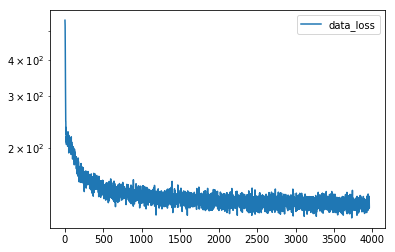

In [619]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [0]:
res    = sess.run(z_samples, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

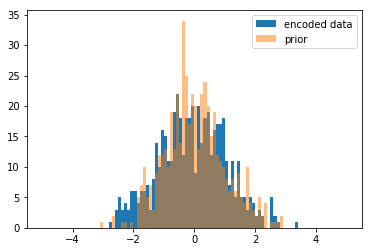

In [621]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

<Figure size 360x360 with 0 Axes>

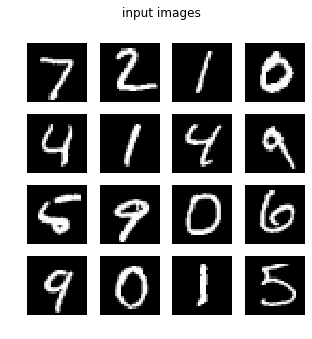

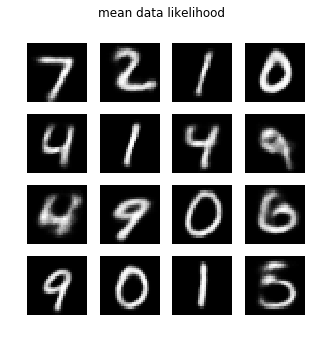

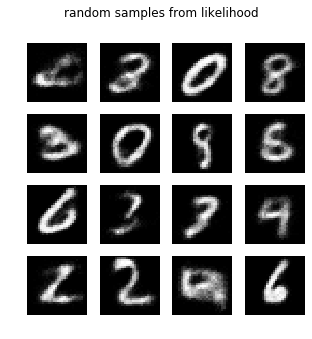

In [622]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_test[0:batch_size], sample_size: 100})
figure(figsize=(5,5))

    
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('random samples from likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:].reshape((-1,28,28)),axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

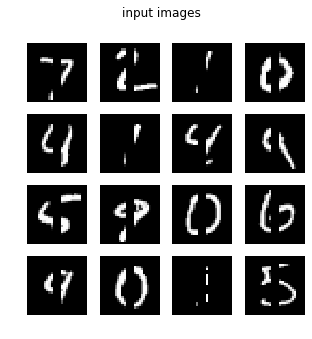

In [631]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[0:28,12:16]=0.
mask = mask.reshape((28*28))

masked_data = x_test[:batch_size2]*[mask]

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')

In [632]:
c, c1, c2, m, m1, m2=sess.run([sigma,sigma_el2o,sigma_elbo, mu, mu_el2o, mu_elbo], feed_dict={x_corr: masked_data, x: x_train[0:batch_size], mymask: mask})

print(c[0])
print(c1[0])
print(c2[0])
print(m[0])
print(m1[0])
print(m2[0])

[0.1245432  0.15220784 0.24803422 0.11794449 0.16619654 0.26942232
 0.0877153  0.072202  ]
[4. 4. 4. 4. 4. 4. 4. 4.]
[0.26447502 0.14890574 0.3052405  0.20065375 0.29046616 0.3105955
 0.09297201 0.11849373]
[-0.04290855  1.2634364   0.72970974  1.7683097  -1.1074923   1.3397386
 -0.15572327  0.42815948]
[10. 10. 10. 10. 10. 10. 10. 10.]
[-2.0280216  -1.0304548  -1.0611761   1.7227806  -1.7630197   1.0534652
 -0.50150543 -0.556403  ]


In [0]:
#sess.run([el2o_el2o,elbo_el2o],feed_dict={x_corr: masked_data, x: x_test[0:batch_size], mymask: mask})

In [0]:
posterior2_loss=[]

In [635]:
lrate=1e-2
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)


78.85596
77.14203
77.02396
77.37147
76.853226
76.90591
76.79808
77.08448
76.71164
76.29155
76.54079
76.90739
77.0061
76.9714
76.23543
76.51811
76.406906
76.64021
76.54285
76.80435


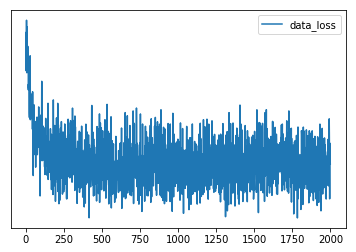

In [636]:
plot(posterior2_loss,label='data_loss')
legend()
yscale('log')

In [637]:
c, c1, m, m1=sess.run([sigma_elbo,sigma_el2o, mu_elbo, mu_el2o], feed_dict={x_corr:masked_data, x: x_test[0:batch_size], mymask: mask})

print(c[0])
print(c1[0])
print(m[0])
print(m1[0])


#print(sess.run([el2o_el2o,elbo_el2o],feed_dict={x_corr: masked_data, x: x_test[0:batch_size], mymask: mask}))
c, c1, m, m1=sess.run([sigma_elbo,sigma_el2o, mu_elbo, mu_el2o], feed_dict={x_corr:masked_data, x: x_test[0:batch_size], mymask: mask})

print(c[0])
print(c1[0])
print(m[0])
print(m1[0])


[0.25147635 0.12149119 0.3527732  0.22230595 0.3589491  0.38149682
 0.1386092  0.10126403]
[4. 4. 4. 4. 4. 4. 4. 4.]
[-1.8833225  -0.94068605 -1.0475633   1.5472018  -1.5055568   0.8483803
 -0.46099788 -0.442331  ]
[10. 10. 10. 10. 10. 10. 10. 10.]
[0.25147635 0.12149119 0.3527732  0.22230595 0.3589491  0.38149682
 0.1386092  0.10126403]
[4. 4. 4. 4. 4. 4. 4. 4.]
[-1.8833225  -0.94068605 -1.0475633   1.5472018  -1.5055568   0.8483803
 -0.46099788 -0.442331  ]
[10. 10. 10. 10. 10. 10. 10. 10.]


In [638]:
a, b, c = sess.run([dptdzz,dpdzz,dpdzz2],feed_dict={x_corr: masked_data, x: x_test[0:batch_size], mymask: mask})
print(a[0], b[0],c[0])

ValueError: ignored

In [609]:
c, c1, m, m1=sess.run([sigma_elbo,sigma_el2o, mu_elbo, mu_el2o], feed_dict={x_corr:masked_data, x: x_test[0:batch_size], mymask: mask})

print(c[0])
print(c1[0])
print(m[0])
print(m1[0])

_, _ = sess.run([update1,update2], feed_dict={x_corr: masked_data, x: x_test[0:batch_size], mymask: mask})
c, c1, m, m1=sess.run([sigma_elbo,sigma_el2o, mu_elbo, mu_el2o], feed_dict={x_corr:masked_data, x: x_test[0:batch_size], mymask: mask})

print(c[0])
print(c1[0])
print(m[0])
print(m1[0])


[0.1389239  0.28382272 0.31662962 0.23051365 0.1759475  0.18218182
 0.30208543 0.07782876]
[4. 4. 4. 4. 4. 4. 4. 4.]
[ 0.39899957  1.3458252   1.2548206  -1.8835267   1.7744976   1.8787975
  0.88805544  0.4057887 ]
[10. 10. 10. 10. 10. 10. 10. 10.]
[0.1389239  0.28382272 0.31662962 0.23051365 0.1759475  0.18218182
 0.30208543 0.07782876]
[0.1389239  0.28382272 0.31662962 0.23051365 0.1759475  0.18218182
 0.30208543 0.07782876]
[ 0.39899957  1.3458252   1.2548206  -1.8835267   1.7744976   1.8787975
  0.88805544  0.4057887 ]
[ 0.39899957  1.3458252   1.2548206  -1.8835267   1.7744976   1.8787975
  0.88805544  0.4057887 ]


In [610]:
m, m1=sess.run([approx_posterior_el2o.mean(),approx_posterior_elbo.mean()], feed_dict={x_corr:masked_data, x: x_test[0:batch_size], mymask: mask})
print(m[0], m1[0])
m, m1=sess.run([approx_posterior_el2o.stddev(),approx_posterior_elbo.stddev()], feed_dict={x_corr:masked_data, x: x_test[0:batch_size], mymask: mask})
print(m[0], m1[0])

[ 0.39899957  1.3458252   1.2548206  -1.8835267   1.7744976   1.8787975
  0.88805544  0.4057887 ] [ 0.39899957  1.3458252   1.2548206  -1.8835267   1.7744976   1.8787975
  0.88805544  0.4057887 ]
[0.1389239  0.28382272 0.31662962 0.23051365 0.1759475  0.18218182
 0.30208543 0.07782876] [0.1389239  0.28382272 0.31662962 0.23051365 0.1759475  0.18218182
 0.30208543 0.07782876]


In [570]:
sess.run([el2o_el2o,elbo_el2o],feed_dict={x_corr: masked_data, x: x_test[0:batch_size], mymask: mask})

[581.18317, 581.18317]

(100, 64, 8)
(100, 64, 8)


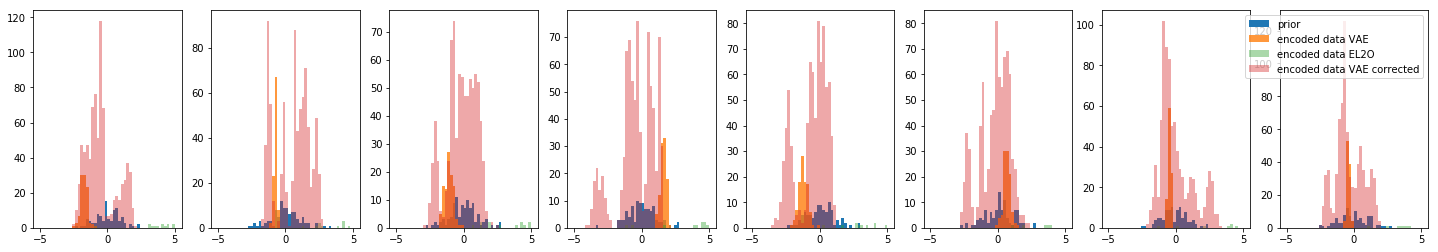

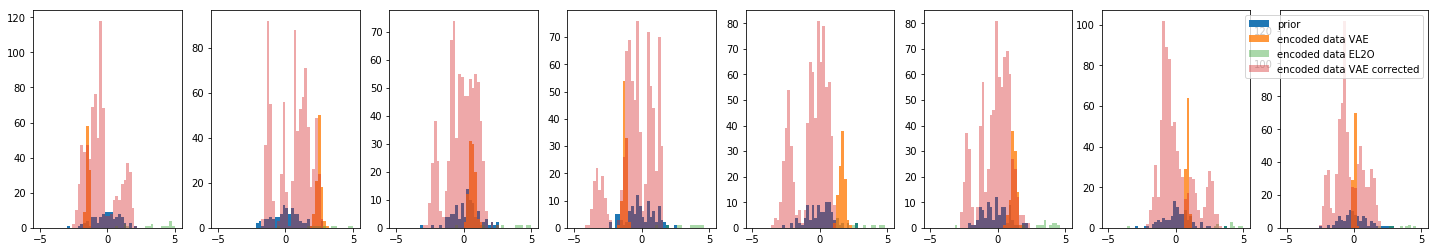

In [639]:
res3 = sess.run(z_samples_el2o,feed_dict={x_corr: masked_data, x: x_test[0:batch_size], sample_size:100, mymask: mask})
res4 = sess.run(z_samples_elbo,feed_dict={x_corr: masked_data, x: x_test[0:batch_size], sample_size:100, mymask: mask})
res2 = sess.run(z_samples,feed_dict={x_corr: masked_data, x: x_test[0:batch_size], sample_size:100, mymask: mask})
print(res3.shape)
print(res4.shape)
for jj in range(2):
  res2_= res2[:,jj,:]
  res3_= res3[:,jj,:]
  res4_= res4
  f=plt.figure()
  f.set_figheight(4)
  f.set_figwidth(25)
  for ii in range(hidden_size):
    subplot(1,hidden_size,ii+1)
    hist(randn(len(res2_[:,ii].flatten())),50,range=[-5,5],alpha=1.,label='prior');
    hist(res2_[:,ii].flatten(),50,range=[-5,5],alpha=0.8, label='encoded data VAE');
    hist(res3_[:,ii].flatten(),50,range=[-5,5],alpha=0.4,label='encoded data EL2O');
    hist(res4_[:,ii].flatten(),50,range=[-5,5],alpha=0.4,label='encoded data VAE corrected');
  legend()
  plt.show()

In [583]:
_, _=sess.run([update3,update4],feed_dict={x_corr: masked_data, x: x_test[0:batch_size], mymask: mask})
c, c1, m, m1=sess.run([sigma_elbo,sigma_el2o, mu_elbo, mu_el2o],feed_dict={x_corr: masked_data, x: x_test[0:batch_size], mymask: mask})
print(c[0])
print(c1[0])
print(m[0])
print(m1[0])

[0.3370181  0.16466019 0.19113266 0.21022883 0.25466123 0.36136413
 0.16047694 0.20221893]
[0.2637416  0.28173277 0.15225218 0.7498162  0.29786262 0.52102613
 0.13954502 0.23063283]
[-2.068574    1.5862986  -0.10383815  1.6265281   0.10611983 -0.48190862
  1.8340169  -1.1598699 ]
[-2.2897422   1.4588752  -0.3079473   4.471467    0.07960534 -0.82652307
  1.9173263  -1.0854642 ]


In [584]:
sess.run([el2o_el2o,elbo_el2o],feed_dict={x_corr: masked_data, x: x_test[0:batch_size], mymask: mask})

[2988.0737, 1393450.1]

(100, 64, 8)


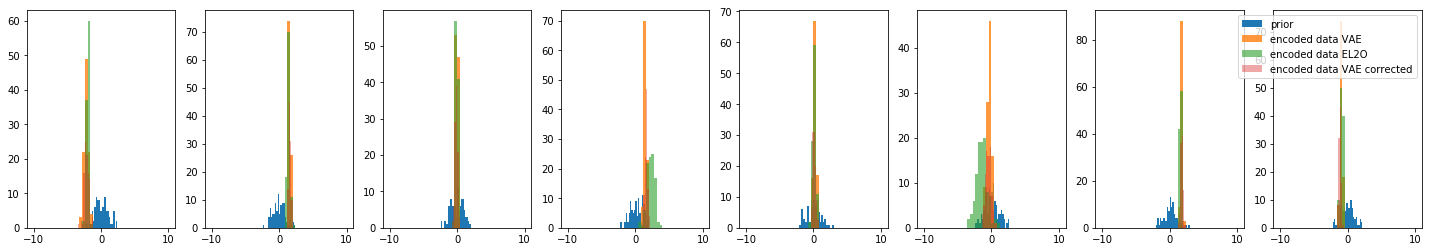

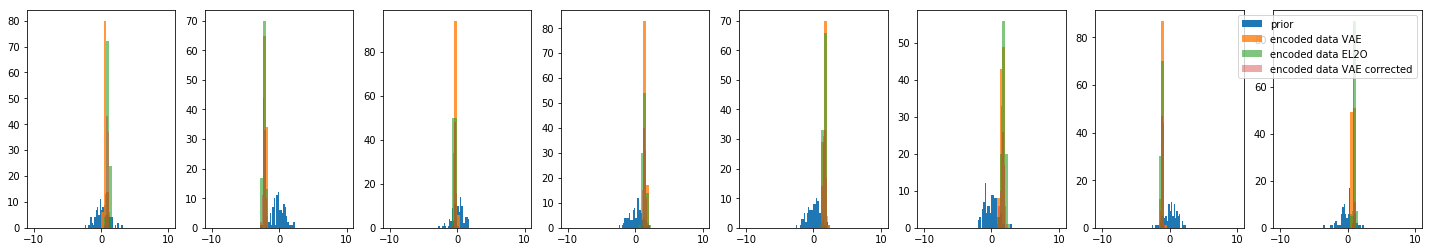

In [585]:
#res3 = sess.run(z_samples_el2o,feed_dict={x_corr: masked_data, x: x_test[0:batch_size], sample_size:100, mymask: mask})
#res4 = sess.run(z_samples_elbo,feed_dict={x_corr: masked_data, x: x_test[0:batch_size], sample_size:100, mymask: mask})
#res2 = sess.run(z_samples,feed_dict={x_corr: masked_data, x: x_test[0:batch_size], sample_size:100, mymask: mask})
print(res3.shape)
for jj in range(2):
  res2_= res2[:,jj,:]
  res3_= res3[:,jj,:]
  res4_= res4[:,jj,:]
  f=plt.figure()
  f.set_figheight(4)
  f.set_figwidth(25)
  for ii in range(hidden_size):
    subplot(1,hidden_size,ii+1)
    hist(randn(len(res2_[:,ii].flatten())),50,range=[-5,5],alpha=1.,label='prior');
    hist(res2_[:,ii].flatten(),50,range=[-10,10],alpha=0.8, label='encoded data VAE');
    hist(res3_[:,ii].flatten(),50,range=[-10,10],alpha=0.6,label='encoded data EL2O');
    hist(res4_[:,ii].flatten(),50,range=[-5,5],alpha=0.4,label='encoded data VAE corrected');
  legend()
  plt.show()

In [586]:
sess.run([el2o_el2o,elbo_el2o],feed_dict={x_corr: masked_data, x: x_test[0:batch_size], mymask: mask})

[3017.5356, 1403609.9]

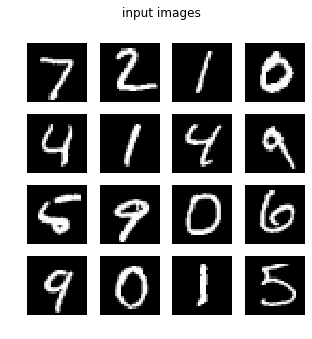

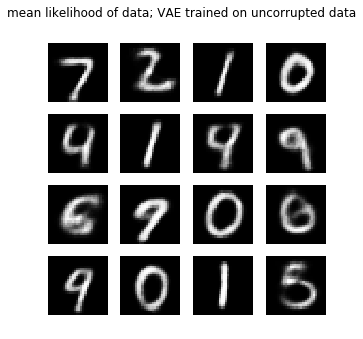

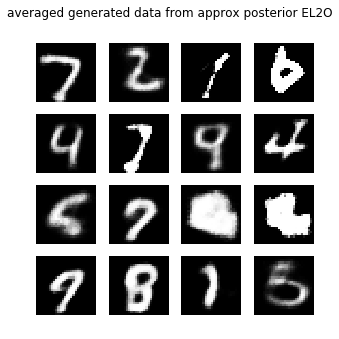

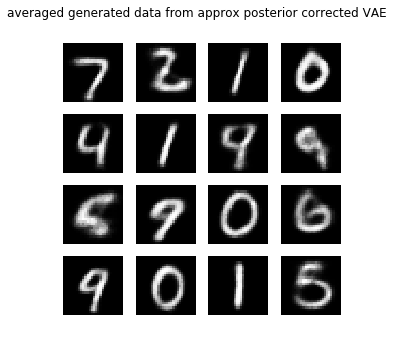

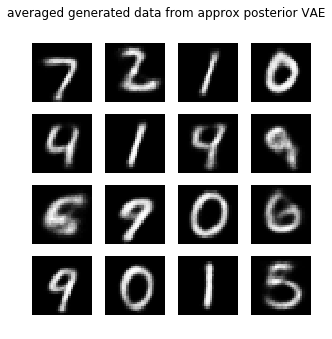

In [587]:
inim, xrecons2, xrecons3 = sess.run([x_corr, x_samples_el2o, x_samples_elbo], feed_dict={x_corr: masked_data, x: x_test[0:batch_size], sample_size:40, mymask: mask})
xmean, xrecon  = sess.run([data_likelihood.mean(),x_samples], feed_dict={x_corr:masked_data, x: masked_data, sample_size:40, mymask: mask})

      
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)     
      imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')

figure(figsize=(5,5))
suptitle('mean likelihood of data; VAE trained on uncorrupted data')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)    
      imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior EL2O')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
      
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior corrected VAE')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(np.mean(xrecons3[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(np.mean(xrecons3[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
      
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior VAE')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')